In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [3]:
columns = [
    'engine_displacement',
    'horsepower',
    'vehicle_weight',
    'model_year',
    'fuel_efficiency_mpg'
]

data = data[columns]

In [4]:
data.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


<Axes: >

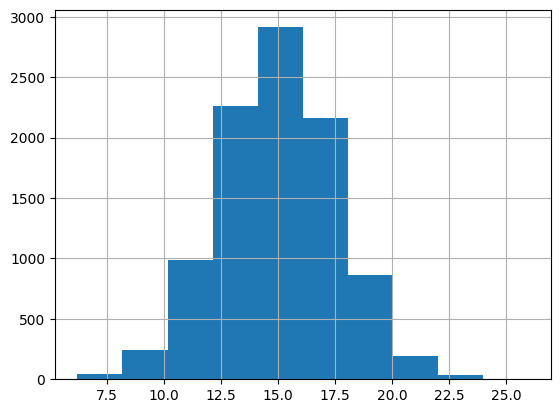

In [5]:
data['fuel_efficiency_mpg'].hist()

In [6]:
data['fuel_efficiency_mpg'].max()

np.float64(25.96722204888372)

# Question 1

In [8]:
data.isna().sum()[data.isna().sum() > 0]

horsepower    708
dtype: int64

# Question 2

In [10]:
data['horsepower'].median()

np.float64(149.0)

Shuffling the data

In [16]:
np.random.seed(42)

n = len(data)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = data.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = df_train['fuel_efficiency_mpg'].values
y_val_orig = df_val['fuel_efficiency_mpg'].values
y_test_orig = df_test['fuel_efficiency_mpg'].values

y_train = np.log1p(df_train['fuel_efficiency_mpg'].values)
y_val = np.log1p(df_val['fuel_efficiency_mpg'].values)
y_test = np.log1p(df_test['fuel_efficiency_mpg'].values)

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

# Question 3

In [17]:
# filling missings function
def fill_missing(df_train, df_val, df_test, value):
    df_train_new = df_train.fillna(value).values
    df_val_new = df_val.fillna(value).values
    df_test_new = df_test.fillna(value).values
    return df_train_new, df_val_new, df_test_new

In [18]:
# function for calculating weights of linear regression
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [19]:
# getting predictions
def get_prediction(w0_0, w_0, df):
    return w0_0 + df.dot(w_0)

In [20]:
# function for RMSE
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return round(np.sqrt(mse), 2)

In [21]:
df_train_new, df_val_new, df_test_new = fill_missing(df_train, df_val, df_test, 0)
w0_0, w_0 = train_linear_regression(df_train_new, y_train)
y_pred = get_prediction(w0_0, w_0, df_val_new)
rmse(y_val, y_pred)

np.float64(0.04)

In [22]:
fp_med_train = np.median(y_train)
df_train_med, df_val_med, df_test_med = fill_missing(df_train, df_val, df_test, fp_med_train)
w0_0, w_0 = train_linear_regression(df_train_new, y_train)
y_pred = get_prediction(w0_0, w_0, df_val_new)
rmse(y_val, y_pred)

np.float64(0.04)

# Question 4

In [23]:
# function for linear regression with regularization
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [24]:
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]

In [29]:
def answer_question4(X, y, X_val, y_val, r_list):
    min_rmse = 10**10
    min_r = 10**10
    for r in r_list:
        w_0, w = train_linear_regression_reg(X, y, r)
        y_val_pred = w_0 + X_val.dot(w)
        rmse_r = round(rmse(y_val, y_val_pred), 2)
        if rmse_r < min_rmse:
            min_rmse = rmse_r
            min_r = r
            w0_best = w_0
            w_best = w
        if rmse_r == min_rmse and r <= min_r:
            min_r = r
    return min_rmse, min_r, w0_best, w_best

In [30]:
best_rmse, min_r, w_0, w = answer_question4(df_train_new, y_train, df_val_new, y_val, r_list)
min_r

0

# Question 5

In [31]:
def question5_answer(df, seed_list):
    val_scores = []
    for seed in seed_list:
        np.random.seed(seed)

        l = len(df)

        len_train = int(0.6 * l)
        len_val = int(0.2 * l)
        len_test = l - len_train - len_val

        idx = np.arange(l)
        np.random.shuffle(idx)

        df_shuffled = df.iloc[idx]

        df_train = df_shuffled.iloc[:len_train].copy()
        df_val = df_shuffled.iloc[len_train:len_train + len_val].copy()
        df_test = df_shuffled.iloc[len_train + len_val:].copy()

        y_train_orig = df_train['fuel_efficiency_mpg'].values
        y_val_orig = df_val['fuel_efficiency_mpg'].values
        y_test_orig = df_test['fuel_efficiency_mpg'].values

        y_train = y_train_orig
        y_val = y_val_orig
        y_test = y_test_orig

        del df_train['fuel_efficiency_mpg']
        del df_val['fuel_efficiency_mpg']
        del df_test['fuel_efficiency_mpg']

        X_train = df_train.fillna(0).values
        X_val = df_val.fillna(0).values
        X_test = df_test.fillna(0).values

        w_0, w = train_linear_regression(X_train, y_train)
        y_pred = w_0 + X_val.dot(w)
        val_scores.append(rmse(y_val, y_pred))
    return val_scores

In [32]:
seed_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [34]:
val_scores = question5_answer(data, seed_list)
val_scores

[np.float64(0.52),
 np.float64(0.52),
 np.float64(0.52),
 np.float64(0.52),
 np.float64(0.51),
 np.float64(0.53),
 np.float64(0.53),
 np.float64(0.51),
 np.float64(0.51),
 np.float64(0.51)]

In [35]:
print(round(np.std(val_scores), 3))

0.007


# Question 6

In [36]:
def question6_answer(df, seed, r):
    np.random.seed(seed)

    l = len(df)

    len_train = int(0.6 * l)
    len_val = int(0.2 * l)
    len_test = l - len_train - len_val

    idx = np.arange(l)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:len_train].copy()
    df_val = df_shuffled.iloc[len_train:len_train + len_val].copy()
    df_test = df_shuffled.iloc[len_train + len_val:].copy()

    df_train = pd.concat([df_train, df_val], ignore_index=True)

    y_train = df_train['fuel_efficiency_mpg'].values
    y_test = df_test['fuel_efficiency_mpg'].values

    del df_train['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    X_train = df_train.fillna(0).values
    X_test = df_test.fillna(0).values

    w_0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w_0 + X_test.dot(w)
    
    return rmse(y_test, y_pred)

In [40]:
answer = question6_answer(data, 9, 0.001)
answer, round(answer, 2)

(np.float64(0.52), np.float64(0.52))